In [1]:
import keras
from keras import layers
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model, to_categorical
import numpy as np

from thaig2p import decode, validate

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from IPython.display import Image, display_png
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
SHORT_VOWELS = "aivueyoxz"
LONG_VOWELS =  "AIVUEYOXZ"
DIPHTHONGS = "JWR"
VOWELS = SHORT_VOWELS + LONG_VOWELS + DIPHTHONGS
ONSETS = ["br","bl","pr","pl","Pr","Pl","fr","fl","dr","tr","Tr","kr","kl","kw","Kr","Kl","Kw"] + \
    ["b","p","P","m","f","d","t","T","n","s","r","l","c","C","k","K","N","w","j","h","?"]
CODAS = ["p","m","f","t","d","n","s","l","c","k","N","w","j","?","-"]

# load data

In [7]:
### load data
train_x = open('data/train_x.txt').read().splitlines()
train_y = open('data/train_y.txt').read().splitlines()
train_y_ipa = open('data/train_y_ipa.txt').read().splitlines()
test_x = open('data/test_x.txt').read().splitlines()
test_y = open('data/test_y.txt').read().splitlines()
test_y_ipa = open('data/test_y_ipa.txt').read().splitlines()

### dict data
data = pd.read_csv('data/thai2phone.csv', names=['g','p'])
data = data[~data.g.str.contains('\.')] # exclude abbreviation
data = data.dropna()

### merge
data = pd.concat([data, pd.DataFrame({'g':train_x, 'p':train_y_ipa})]).reset_index(drop=True)

### add <EOS>= ^  and <SOS> = $
test_x = ['^'+x+'$' for x in test_x] 
data['g'] = data.g.apply(lambda x: '^'+x+'$')
data

,g,p
0,^กก$,kok2
1,^กกกอด$,kok2 kXt2
2,^กกช้าง$,kok2 CAN4
3,^กกธูป$,kok2 TUp3
4,^กกหู$,kok2 hU-5
...,...,...
34544,^สิทธิพงษ์$,sit2 Ti-4 PoN1
34545,^ธีรวีร์$,TI-1 ra-1 wI-1
34546,^นิภากร$,ni-4 PA-1 kXn1
34547,^จุฑาธิป$,cu-2 TA-1 Tip4


# train data

In [8]:
def syl_split(syl):
    tone = syl[-1] # prA-1 -> 1
    coda = syl[-2] # prA-1 -> -
    vowel = syl[-3] # prA-1 -> A
    onset = syl[:-3] # # prA-1 -> pr
    return onset, vowel, coda, tone

def make_output(phon, n=0): # n: onset, vowel, coda, tone
    syls = phon.split()
    splitted = [syl_split(syl)[n] for syl in syls]
    if n==0:
        return [onset2id[x] for x in splitted]
    elif n==1:
        return [vowel2id[x] for x in splitted]
    elif n==2:
        return [coda2id[x] for x in splitted]
    elif n==3:
        return [tone2id[x] for x in splitted]

thai2id = {'<PAD>':0, '^':1, '$':2, ' ':3}
for i in range(3585, 3674): # ก=3585->4, ๙=3673
    thai2id[chr(i)] = i - 3581
id2thai = {v:k for k,v in thai2id.items()}

onset2id = {'<PAD>':0,'<SOS>':1}
for c in ONSETS:
    onset2id[c] = max(onset2id.values()) + 1
id2onset = {v:k for k,v in onset2id.items()}

coda2id = {'<PAD>':0,'<SOS>':1}
for c in CODAS:
    coda2id[c] = max(coda2id.values()) + 1
id2coda = {v:k for k,v in coda2id.items()}

vowel2id = {'<PAD>':0,'<SOS>':1}
for c in VOWELS:
    vowel2id[c] = max(vowel2id.values()) + 1
id2vowel = {v:k for k,v in vowel2id.items()}

tone2id = {'<PAD>':0,'<SOS>':1,'1':2,'2':3,'3':4,'4':5,'5':6}
id2tone = {v:k for k,v in tone2id.items()}



In [9]:
print(data.p[100])
make_output(data.p[100], 3)

ka-2 ra-4 nI-1 cam1 pen1


[3, 5, 2, 2, 2]

In [10]:
# max len of input character length
print(max(map(len, data.g)))

# max len of output syllable length
print(max([len(x.split(" ")) for x in data.p]))

52
20


In [11]:
## validation of data ##
for phon in data.p:
    try:
        make_output(phon, n=3)
    except:
        print(phon)

In [57]:
output_maxlen = 20

### encoder input
x_enc = [[thai2id[c] for c in word] for word in data.g]
x_enc = pad_sequences(x_enc, padding='post', maxlen=55, value=0)

x_enc_test = [[thai2id[c] for c in word] for word in test_x]
x_enc_test = pad_sequences(x_enc_test, padding='post', maxlen=55, value=0)


### decoder input
x_dec0 = [[1]+make_output(phon, n=0) for phon in data.p] # onset
x_dec1 = [[1]+make_output(phon, n=1) for phon in data.p] # vowel
x_dec2 = [[1]+make_output(phon, n=2) for phon in data.p] # coda
x_dec3 = [[1]+make_output(phon, n=3) for phon in data.p] # tone
x_dec4 = [np.arange(len(seq), 0, -1) for seq in x_dec0] # syllables left [4,3,2,1]


### padding ###
x_dec0 = pad_sequences(x_dec0, padding='post', maxlen=output_maxlen, value=0)
x_dec1 = pad_sequences(x_dec1, padding='post', maxlen=output_maxlen, value=0)
x_dec2 = pad_sequences(x_dec2, padding='post', maxlen=output_maxlen, value=0)
x_dec3 = pad_sequences(x_dec3, padding='post', maxlen=output_maxlen, value=0)
x_dec4 = pad_sequences(x_dec4, padding='post', maxlen=output_maxlen, value=0)


### check ###

print('Encoder Input:', x_enc.shape, x_enc_test.shape)
print('Decoder Onset:', x_dec0.shape) # onset
print('Decoder Vowel:', x_dec1.shape) # vowel
print('Decoder Coda :', x_dec2.shape) # coda
print('Decoder Tone :', x_dec3.shape) # tone
print('Decoder Syl  :', x_dec4.shape) # syllables left

i = 100

print(x_dec0[i]) # begin with 1 = <SOS>
print(x_dec1[i])
print(x_dec2[i])
print(x_dec3[i])
print(x_dec4[i])

Encoder Input: (34549, 55) (700, 55)
Decoder Onset: (34549, 20)
Decoder Vowel: (34549, 20)
Decoder Coda : (34549, 20)
Decoder Tone : (34549, 20)
Decoder Syl  : (34549, 20)
[ 1 33 29 27 31 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 1  2  2 12  2  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 1 16 16 16  3  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[1 3 5 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[6 5 4 3 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [59]:
### one-hot vector for decoder output ###
y0 = to_categorical(x_dec0, num_classes=len(onset2id)) # onset
y1 = to_categorical(x_dec1, num_classes=len(vowel2id)) # vowel
y2 = to_categorical(x_dec2, num_classes=len(coda2id)) # coda
y3 = to_categorical(x_dec3, num_classes=7) # tone = 2-6, <PAD> = 0, <SOS> = 1
y4 = x_dec4

print('Output [Onset]:', y0.shape)
print('Output [Vowel]:', y1.shape)
print('Output [Coda] :', y2.shape)
print('Output [Tone] :', y3.shape)
print('Output [EOS]  :', y4.shape)



Output [Onset]: (34549, 20, 40)
Output [Vowel]: (34549, 20, 23)
Output [Coda] : (34549, 20, 17)
Output [Tone] : (34549, 20, 7)
Output [EOS]  : (34549, 20)


# make model

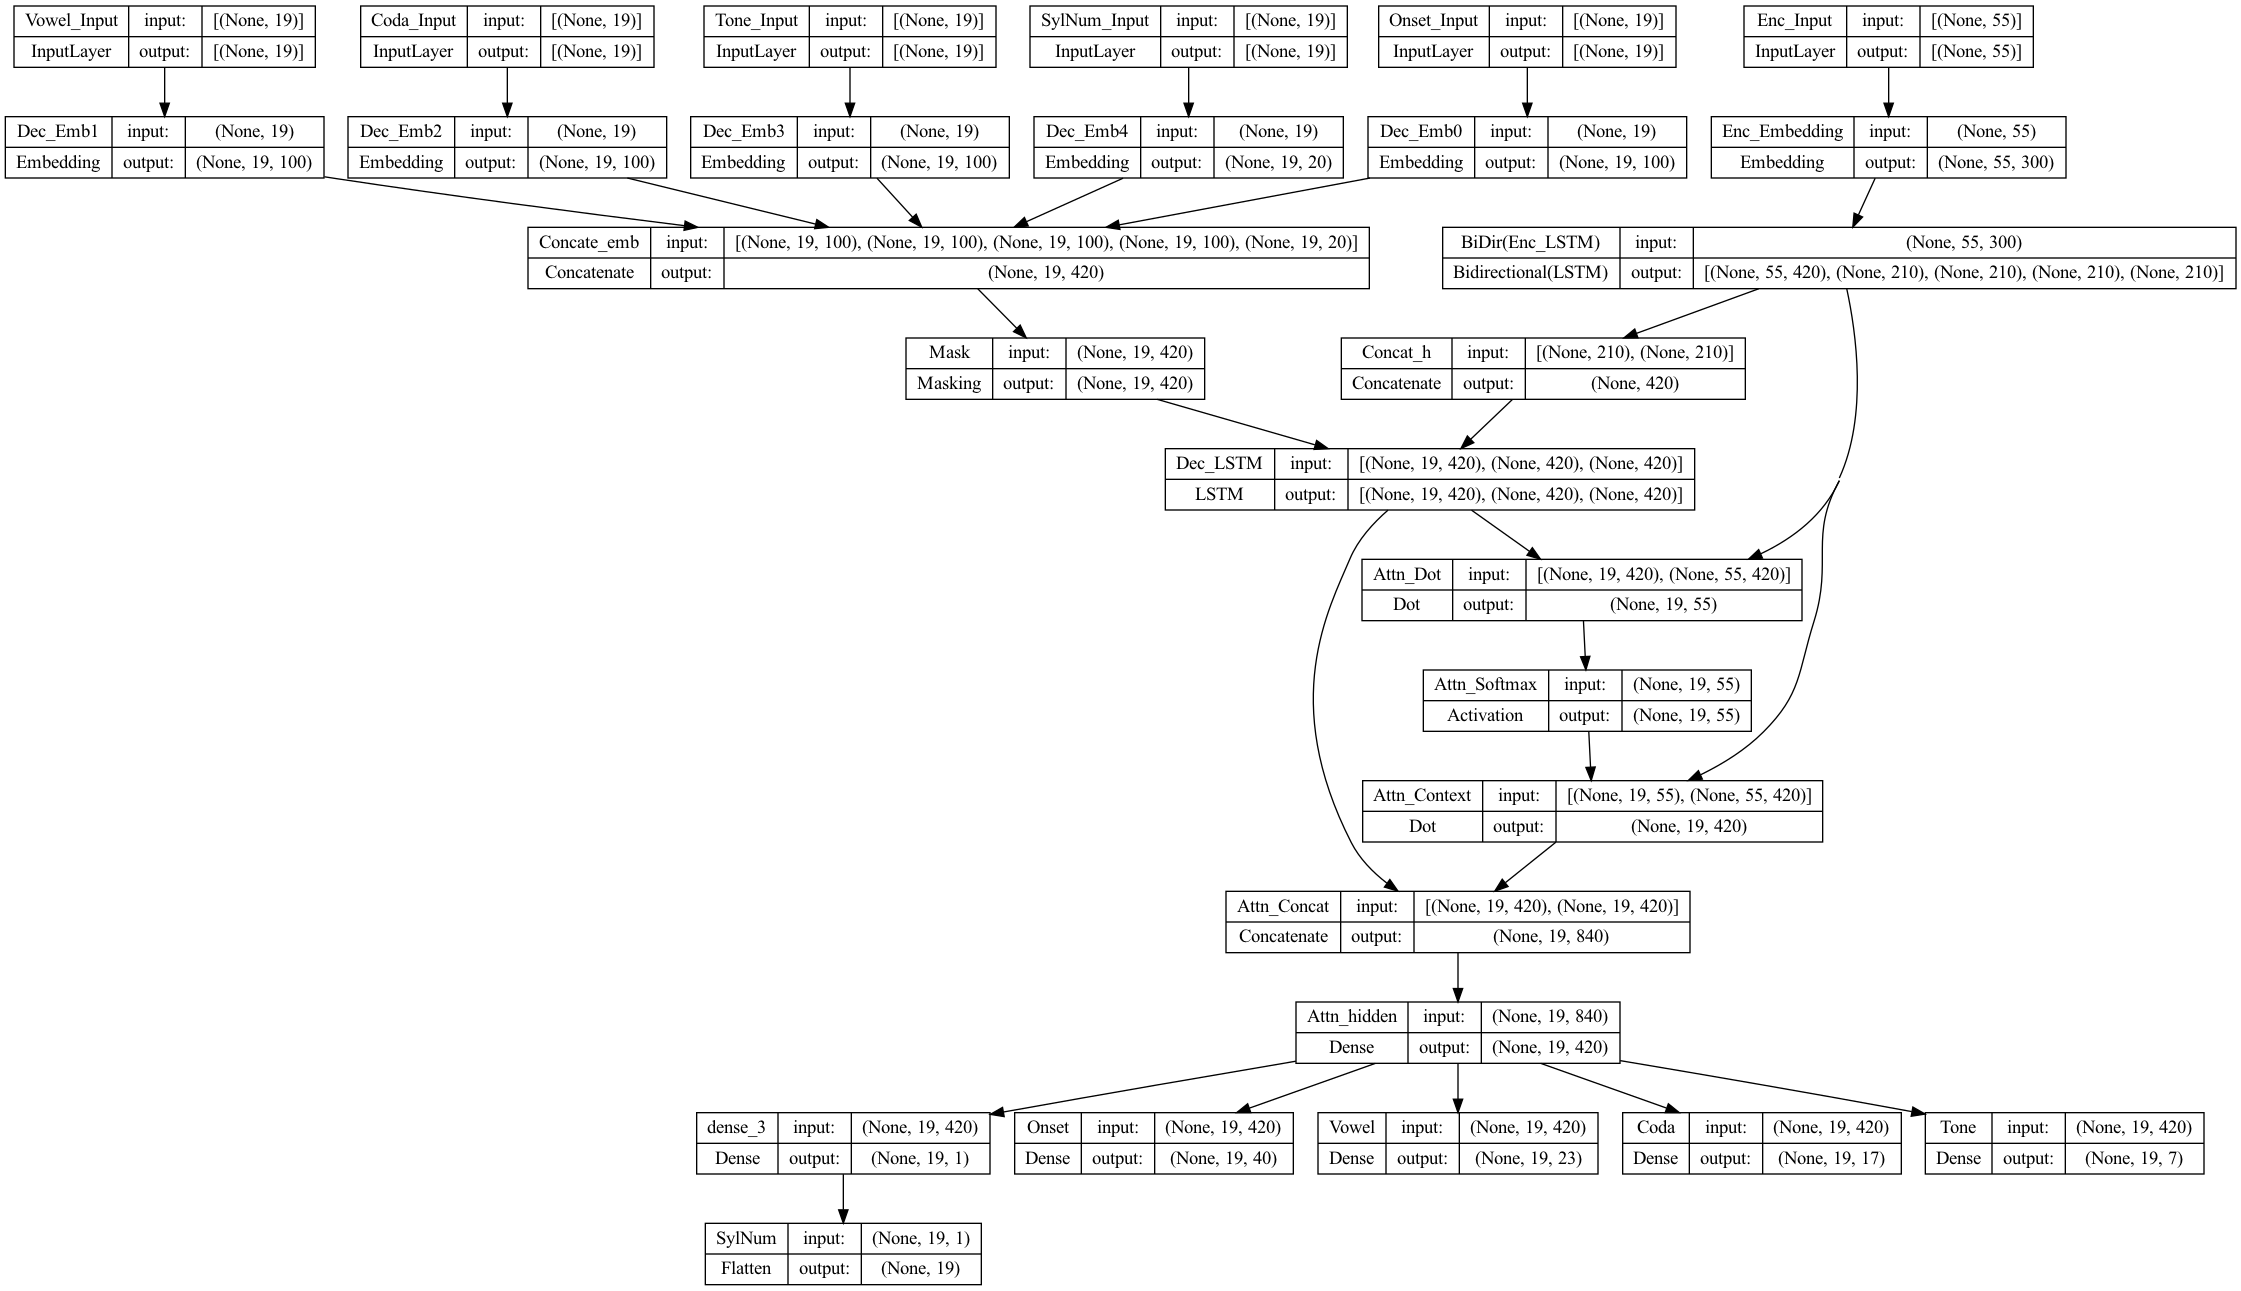

In [81]:
input_vocab = len(thai2id)
input_len = x_enc.shape[1]
output_len = output_maxlen-1 # delete <SOS> for decoder target
enc_emb_dim = 300
## enc_lstm_dim*2 = dec_emb_dim*4 + dec_eos_dim
enc_lstm_dim = 210
dec_emb_dim = 100
dec_eos_dim = 20
dec_lstm_dim = dec_emb_dim*4 + dec_eos_dim
lstm_dropout = 0.2

### ENCODER ###
input_enc= layers.Input(batch_size=None, shape=(input_len,), name='Enc_Input')
emb_enc = layers.Embedding(input_dim = input_vocab, # num of vocab = num of ID dict
                                    input_length = input_len,
                                    output_dim = enc_emb_dim,
                                    mask_zero = True,
                                    name = 'Enc_Embedding')
lstm_enc = layers.Bidirectional(layers.LSTM(enc_lstm_dim,
                                        return_sequences=True, # use only final output when w/o attention -> return (batch, lstm_dim)
                                        return_state=True,
                                        recurrent_dropout=lstm_dropout,
                                        name='Enc_LSTM'), name='BiDir') # return: output, h1, c1, h2, c2
concat_h = layers.Concatenate(name='Concat_h') # concatnate bidirectional output of state h 
concat_c = layers.Concatenate(name='Concat_c') # concatnate bidirectional output of state c

### DECODER ###
class Attention:
    def __init__(self, unit=256, emb_dim=256):
        self.dot = layers.Dot(axes=[2,2], name='Attn_Dot') # (batch, dec_seq_length, "lstm_dim") * (batch, enc_seq_length, "lstm_dim") -> weight (batch, dec_seq_length, enc_seq_length) 
        #self.sqrt = layers.Lambda(lambda x: x/emb_dim**0.5, name='Sqrt') # scaling by square root : */√dim
        self.softmax = layers.Activation(activation='softmax', name='Attn_Softmax')
        self.context = layers.Dot(axes=[2,1], name='Attn_Context') # weight (batch, dec_seq_length, "enc_seq_length") * (batch, "enc_seq_length", dim) -> (batch, dec_seq_length, dim)
        self.concat = layers.Concatenate(name='Attn_Concat') # concate context and decoder output
        self.hidden = layers.Dense(unit, activation='tanh', name='Attn_hidden')

    def __call__(self, enc_output, dec_output):
        attention_dot = self.dot([dec_output, enc_output])
        #attention_weight = self.softmax(self.sqrt(attention_dot))
        attention_weight = self.softmax(attention_dot)
        context_vector = self.context([attention_weight, enc_output])
        concat_vector = self.concat([context_vector, dec_output])
        return self.hidden(concat_vector)

class Decoder:
    def __init__(self):
        self.input0 = layers.Input(batch_size=None, shape=(output_len,), name='Onset_Input') # onset
        self.input1 = layers.Input(batch_size=None, shape=(output_len,), name='Vowel_Input') # vowel
        self.input2 = layers.Input(batch_size=None, shape=(output_len,), name='Coda_Input') # coda
        self.input3 = layers.Input(batch_size=None, shape=(output_len,), name='Tone_Input') # tone
        self.input4 = layers.Input(batch_size=None, shape=(output_len,), name='SylNum_Input') # syllables left
        self.input_h = layers.Input(batch_size=None, shape=(enc_lstm_dim*2,), name='Dec_Input_h') # only for predict
        self.input_c = layers.Input(batch_size=None, shape=(enc_lstm_dim*2,), name='Dec_Input_c') # only for predict
        self.emb_dec0 = layers.Embedding(input_dim=len(onset2id), input_length=output_len, output_dim=dec_emb_dim, mask_zero=True, name = 'Dec_Emb0')
        self.emb_dec1 = layers.Embedding(input_dim=len(vowel2id), input_length=output_len, output_dim=dec_emb_dim, mask_zero=True, name = 'Dec_Emb1')
        self.emb_dec2 = layers.Embedding(input_dim=len(coda2id), input_length=output_len, output_dim=dec_emb_dim, mask_zero=True, name = 'Dec_Emb2')
        self.emb_dec3 = layers.Embedding(input_dim=len(tone2id), input_length=output_len, output_dim=dec_emb_dim, mask_zero=True, name = 'Dec_Emb3')
        self.emb_dec4 = layers.Embedding(input_dim=output_maxlen+1, input_length=output_len, output_dim=dec_eos_dim, mask_zero=True, name = 'Dec_Emb4') # EOS or not
        self.concat_emb = layers.Concatenate(name='Concate_emb') # cancatenate all embeddings
        self.mask = layers.Masking(mask_value=0.0, name='Mask')
        self.lstm_dec = layers.LSTM(dec_lstm_dim, # twice as lstm dim of encoder
                                return_sequences=True,
                                return_state=True,
                                recurrent_dropout=lstm_dropout,
                                name='Dec_LSTM')
        self.attention = Attention(unit=dec_lstm_dim, emb_dim=dec_lstm_dim)
        self.dense0 = layers.Dense(len(onset2id), activation='softmax', name='Onset')
        self.dense1 = layers.Dense(len(vowel2id), activation='softmax', name='Vowel')
        self.dense2 = layers.Dense(len(coda2id), activation='softmax', name='Coda')
        self.dense3 = layers.Dense(len(tone2id), activation='softmax', name='Tone')
        self.dense4 = layers.Dense(1, activation='relu')
        self.flatten = layers.Flatten(name='SylNum')

    def __call__(self, encoder_output, input_h, input_c):
        x0 = self.emb_dec0(self.input0)
        x1 = self.emb_dec1(self.input1)
        x2 = self.emb_dec2(self.input2)
        x3 = self.emb_dec3(self.input3)
        x4 = self.emb_dec4(self.input4)
        emb_dec = self.mask(self.concat_emb([x0,x1,x2,x3,x4]))
        dec_output, h, c = self.lstm_dec(emb_dec, initial_state=[input_h, input_c]) # for train, input_h and input_c are output of encoder
        x = self.attention(enc_output, dec_output)
        output0 = self.dense0(x)
        output1 = self.dense1(x)
        output2 = self.dense2(x)
        output3 = self.dense3(x)
        output4 = self.flatten(self.dense4(x))
        return output0, output1, output2, output3, output4, h, c


## Encoder call
enc_output, h1, c1, h2, c2 = lstm_enc(emb_enc(input_enc))
enc_state_h = concat_h([h1, h2])
enc_state_c = concat_c([c1, c2])

## Decoder call
decoder = Decoder()
output0, output1, output2, output3, output4, h, c = decoder(enc_output, enc_state_h, enc_state_h)
output0_pred, output1_pred, output2_pred, output3_pred, output4_pred, h_pred, c_pred = decoder(enc_output, decoder.input_h, decoder.input_c)


### Build Models
## for train
model = keras.models.Model(inputs=[
    input_enc,
    decoder.input0,
    decoder.input1,
    decoder.input2,
    decoder.input3,
    decoder.input4], outputs=[
    output0,
    output1,
    output2,
    output3,
    output4])
## for predict
model_pred_enc = keras.models.Model(input_enc, [enc_output, enc_state_h, enc_state_c])

model_pred_dec = keras.models.Model(inputs=[
    enc_output,
    decoder.input0,
    decoder.input1,
    decoder.input2,
    decoder.input3,
    decoder.input4,
    decoder.input_h,
    decoder.input_c], outputs=[
    output0_pred,
    output1_pred,
    output2_pred,
    output3_pred,
    output4_pred,
    h_pred,
    c_pred])


model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics='accuracy')

plot_model(model, show_shapes=True )

In [69]:
history = model.fit(x=[
    x_enc,
    x_dec0[:,:-1],
    x_dec1[:,:-1],
    x_dec2[:,:-1],
    x_dec3[:,:-1],
    x_dec4[:,:-1]], y=[
    y0[:,1:,:],
    y1[:,1:,:],
    y2[:,1:,:],
    y3[:,1:,:],
    y4[:,1:]
    ],
epochs=10,
validation_split=0.2
)

Epoch 1/10
864/864 [==============================] - 406s 464ms/step - loss: 7.1310 - Onset_loss: 0.3670 - Vowel_loss: 0.2666 - Coda_loss: 0.2609 - Tone_loss: 0.1950 - SylNum_loss: 6.0415 - Onset_accuracy: 0.9108 - Vowel_accuracy: 0.9311 - Coda_accuracy: 0.9232 - Tone_accuracy: 0.9310 - SylNum_accuracy: 0.9938 - val_loss: 5.0388 - val_Onset_loss: 0.0866 - val_Vowel_loss: 0.0955 - val_Coda_loss: 0.1151 - val_Tone_loss: 0.0994 - val_SylNum_loss: 4.6421 - val_Onset_accuracy: 0.9755 - val_Vowel_accuracy: 0.9712 - val_Coda_accuracy: 0.9576 - val_Tone_accuracy: 0.9621 - val_SylNum_accuracy: 1.0000
Epoch 2/10
864/864 [==============================] - 406s 470ms/step - loss: 5.9631 - Onset_loss: 0.0286 - Vowel_loss: 0.0334 - Coda_loss: 0.0422 - Tone_loss: 0.0458 - SylNum_loss: 5.8130 - Onset_accuracy: 0.9924 - Vowel_accuracy: 0.9901 - Coda_accuracy: 0.9864 - Tone_accuracy: 0.9843 - SylNum_accuracy: 1.0000 - val_loss: 4.8029 - val_Onset_loss: 0.0255 - val_Vowel_loss: 0.0355 - val_Coda_loss: 0

<AxesSubplot:>

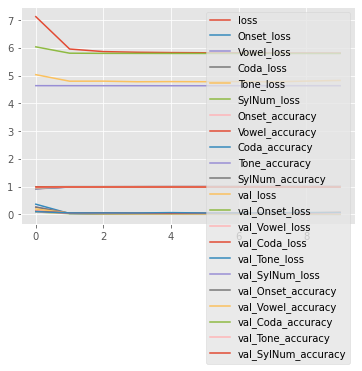

In [70]:
#model_pred_enc = keras.models.Model(input_enc, [enc_output, enc_state_h, enc_state_c])
pd.DataFrame(history.history).plot()

# predict

In [78]:
def predict_one(input_seq): # input must be 2D array
    enc_output, h, c = model_pred_enc.predict(input_seq, verbose=0) # verbose=0: not print
    target_seq0 = np.zeros((1, output_len)) # generate target seq of length 1 e.g. [[1,0,0,..]]
    target_seq1 = np.zeros((1, output_len)) # generate target seq of length 1 e.g. [[1,0,0,..]]
    target_seq2 = np.zeros((1, output_len)) # generate target seq of length 1 e.g. [[1,0,0,..]]
    target_seq3 = np.zeros((1, output_len)) # generate target seq of length 1 e.g. [[1,0,0,..]]
    target_seq4 = np.zeros((1, output_len)) # generate target seq of length 1 e.g. [[1,0,0,..]]
    target_seq0[0, 0] = 1 # <sos> ID=1
    target_seq1[0, 0] = 1 # <sos> ID=1
    target_seq2[0, 0] = 1 # <sos> ID=1
    target_seq3[0, 0] = 1 # <sos> ID=1
    target_seq4[0, 0] = 5 # <sos> ID=1
    decoded = ''
    for _ in range(output_len):
        onset, vowel, coda, tone, eos, h, c = model_pred_dec.predict([enc_output, target_seq0, target_seq1, target_seq2, target_seq3, target_seq4, h, c], verbose=0) # not print
        #if np.argmax(eos[0]) == 0:
            #break
        target_seq0[0,0] = np.argmax(onset[0][0])
        target_seq1[0,0] = np.argmax(vowel[0][0])
        target_seq2[0,0] = np.argmax(coda[0][0])
        target_seq3[0,0] = np.argmax(tone[0][0])
        target_seq4[0,0] = np.argmax(eos[0])
        decoded += (id2onset[np.argmax(onset[0][0])] + id2vowel[np.argmax(vowel[0][0])] + id2coda[np.argmax(coda[0][0])] + id2tone[np.argmax(tone[0][0])] + ' ')
    return decoded

In [83]:
i = 7

print(predict_one(x_enc_test[i:i+1]))
print(test_y[i])

bled3 fZ-<PAD> fZ-2 fZ-4 fZ-4 fZ-4 fZ-4 fZ-4 fZ-4 fZ-4 fZ-4 fZ-4 fZ-4 fZ-4 fZ-4 fZ-4 fZ-4 fZ-4 fZ-4 
khanet


In [73]:
predict_one(x_enc_test[i:i+1])

''

In [46]:
x_enc_test[i]

array([ 1, 30, 38, 51, 35, 53, 33, 38, 38, 22,  2,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0], dtype=int32)

In [165]:
for p in data.p:
    if validate(p):
        pass
    else:
        print(p)

Ta-1 wan1 ha-1 Taj-1
